# Multi-modal Walkthrough

In [1]:
!pip install x_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.8 MB/s eta 0:00:00


## Imports

In [2]:
from typing import *
from pathlib import Path
import torch
import torch.nn as nn

## Download Datasets

Downloading Dataset and assign it into ds

In [3]:
from datasets import load_dataset, Features, Value

ds = load_dataset("ashraq/esc50", split="train")

# Define new column type to override Audio decoding
raw_audio_features = Features({
    "bytes": Value("binary"),
    "path": Value("string"),
})

# Apply casting
ds = ds.cast_column("audio", raw_audio_features)
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/345 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00002-2f1ab7b824ec75(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

data/train-00001-of-00002-27425e5c1846b4(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'audio'],
    num_rows: 2000
})

In [4]:
# checking a random element in ds
ds[10]

{'filename': '1-103999-A-30.wav',
 'fold': 1,
 'target': 30,
 'category': 'door_wood_knock',
 'esc10': False,
 'src_file': 103999,
 'take': 'A',
 'audio': {'bytes': b'RIFF\xcc\xba\x06\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00D\xac\x00\x00\x88X\x01\x00\x02\x00\x10\x00data\xa8\xba\x06\x00\x01\x00\x01\x00\x01\x00\x01\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\xfe\xff\xfe\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x01\x00\x01\x00\x01\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x01\x00\x01\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\xff\xff\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\xff\xff\x00\x00\x01\x00\x00\x00\x00\x00\xff\xff\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

Keeping necessary columns in ds and removing all other columns

In [5]:
# Keep only necessary columns
ds = ds.remove_columns([
    c for c in ds.column_names
    if c not in ["filename", "category", "audio"]
])

Format the category values

Replacing '_' with ' '

In [6]:
def format_category(sample):
  sample["category"] = sample["category"].replace("_", " ")
  return sample

ds = ds.map(format_category)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
# Examining column names
print(ds.column_names)

['filename', 'category', 'audio']


Checking the sampling rate of audio in ds

In [8]:
import torchaudio

i = 10 # Example index
sample = ds[i]
waveform, sample_rate = torchaudio.load(sample["audio"]["bytes"])
print(f"{waveform.shape=}, {sample_rate=}")

waveform.shape=torch.Size([1, 220500]), sample_rate=44100


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Resampling function


In [9]:
# Function to resample audio and apply to dataset
def resample_audio_column(sample):
    waveform, original_freq = torchaudio.load(sample["audio"]["bytes"])
    target_freq: int = 24000
    if original_freq == target_freq:    # no resampling

        resampled_waveform = waveform
    else:
        resampler = torchaudio.transforms.Resample(
            orig_freq= original_freq,
            new_freq= target_freq
        )
        resampled_waveform = resampler(waveform)
    sample["audio_24k"] = {"bytes": None, "path": None, "array": resampled_waveform.squeeze().numpy(), "sampling_rate": target_freq}
    return sample

# Applying the resampling functio to all elements of ds
ds = ds.map(resample_audio_column)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
print(ds.column_names)

['filename', 'category', 'audio', 'audio_24k']


In [11]:
# Replace the original audio column with the resampled one in ds
ds = ds.remove_columns(["audio"])
ds = ds.rename_column("audio_24k", "audio")
print(ds.column_names)

['filename', 'category', 'audio']


In [12]:
i = 0 # You can change this index to access different elements
print(ds[i]["audio"]["sampling_rate"])

24000


Playing a random audio file to make sure dataset was downloaded correctly

In [13]:
from IPython.display import Audio

# Select the first sample as an example
sample_to_play = ds[200]

# Extract the audio array and sampling rate from the 'audio' column
audio_array = sample_to_play["audio"]["array"]
sampling_rate = sample_to_play["audio"]["sampling_rate"]
category = sample_to_play["category"]

print(f"Playing sample from category: {category}")

# Play the audio
Audio(data=audio_array, rate=sampling_rate)

Playing sample from category: snoring


Splitting the dataset into train and test.

In [14]:
splits = ds.train_test_split(test_size=0.1)
splits

DatasetDict({
    train: Dataset({
        features: ['filename', 'category', 'audio'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['filename', 'category', 'audio'],
        num_rows: 200
    })
})

In [15]:
import torchaudio

sample: dict = splits["train"][0]
sample.keys()

dict_keys(['filename', 'category', 'audio'])

Downloading pretrained Encodec model

In [16]:
from transformers import EncodecModel, AutoProcessor

AUDIO_MODEL: str = "facebook/encodec_24khz" # @param {type:"string"}

audio_model = EncodecModel.from_pretrained(AUDIO_MODEL)
audio_processor = AutoProcessor.from_pretrained(AUDIO_MODEL)

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating the fps and number of frames in the audio

In [17]:
from operator import mul
from functools import reduce

fps: float = audio_model.config.sampling_rate / reduce(mul, audio_model.config.upsampling_ratios, 1)
print(f"{fps=}")

audio_length_s: int = 5

num_audio_frames: int = int(fps * audio_length_s)
print(f"{num_audio_frames=}")

fps=75.0
num_audio_frames=375


Downloading the text encoder

In [18]:
# @title Text Encoder

from sentence_transformers import SentenceTransformer

text_encoder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
text_encoder

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False, 'architecture': 'MPNetModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [19]:
import torchaudio

sample: dict = splits["train"][5]
sample.keys()

dict_keys(['filename', 'category', 'audio'])

In [20]:
print(sample["category"])

door wood knock


Generating text embeddings from 'category'

In [21]:
text_embeddings: torch.Tensor = text_encoder.encode(
    [category],
    convert_to_tensor=True,
    normalize_embeddings=True
).clone()

text_embeddings.shape


torch.Size([1, 768])

Preparing the text embeddings and projecting it to the correct shape, to be used as input for JEPA_base

In [22]:
import torch.nn as nn

text_embed_dim: int = text_encoder.get_sentence_embedding_dimension()
print(f"{text_embed_dim=}")

num_audio_channels: int = 2 # Based on Encodec model
print(f"{num_audio_channels=}")
print(f"{num_audio_frames=}") # Defined in a previous cell

# Define a linear layer to project text embeddings
proj_text_to_audio = nn.Linear(
    text_embed_dim,
    num_audio_channels * num_audio_frames
)

# Apply the linear projection and reshape to match audio embeddings
text_embeddings_proj = proj_text_to_audio(
    text_embeddings
).view(-1, num_audio_channels, num_audio_frames)

print(f"{text_embeddings_proj.shape=}")

text_embed_dim=768
num_audio_channels=2
num_audio_frames=375
text_embeddings_proj.shape=torch.Size([1, 2, 375])


Preparing the raw audio into specific format as Enoced and JEPA model expects

In [23]:
# Access the audio array from the sample
audio_array = sample["audio"]["array"]

# Process the audio with the audio_processor
processed_audio = audio_processor(
    raw_audio=audio_array,
    sampling_rate=audio_processor.sampling_rate,
    return_tensors="pt"
)

# Print the shape of the processed audio input values
print(processed_audio["input_values"].shape)

torch.Size([1, 1, 120000])


Function to format category into tensor format

In [24]:
def process_category(category: str, text_encoder, proj_text_to_audio, num_audio_channels: int, num_audio_frames: int) -> torch.Tensor:

    # Get text embedding (encode a list containing the single category)
    text_embeddings: torch.Tensor = text_encoder.encode(
        [category],
        convert_to_tensor=True,
        normalize_embeddings=True
    ).clone()

    # Apply linear projection and reshape
    text_embeddings_proj = proj_text_to_audio(
        text_embeddings
    ).view(-1, num_audio_channels, num_audio_frames)

    return text_embeddings_proj

testing the function

In [25]:
# Get a sample category from the dataset (e.g., the first one)
sample_category = ds[0]["category"]
print(f"Sample category: {sample_category}")

# Test the process_category function
projected_embedding = process_category(
    sample_category,
    text_encoder,
    proj_text_to_audio,
    num_audio_channels,
    num_audio_frames
)

# Print the shape of the output
print(f"Shape of projected embedding: {projected_embedding.shape}")

Sample category: dog
Shape of projected embedding: torch.Size([1, 2, 375])


Making tensors of audio and text and storing it in a dictionary as training and test splits

In [26]:
processed_audio_data = {}

# Iterate through both train and test splits
for split_name, dataset in splits.items():
    processed_audio_list = []
    print(f"Processing {split_name} split...")
    for i, sample in enumerate(dataset):
        try:
            # Access the audio array from the sample
            audio_array = sample["audio"]["array"]
            category = sample["category"] # Get the category

            # Process the audio with the audio_processor
            processed_audio = audio_processor(
                raw_audio=audio_array,
                sampling_rate=audio_processor.sampling_rate,
                return_tensors="pt"
            )

            # Process the category using the process_category function
            processed_category_tensor = process_category(
                category,
                text_encoder,
                proj_text_to_audio,
                num_audio_channels,
                num_audio_frames
            )

            # Include category tensor and original category string with processed audio
            processed_audio['category_tensor'] = processed_category_tensor
            processed_audio['category'] = category # Add original category string
            processed_audio_list.append(processed_audio)

            # Optional: Print shape and category for a few samples to verify
            if i < 5:
                print(f"  Sample {i} processed audio shape: {processed_audio['input_values'].shape}, Category Tensor shape: {processed_audio['category_tensor'].shape}, Category: {processed_audio['category']}")

        except Exception as e:
            print(f"  Could not process sample {i}: {e}")
            # Handle samples that might cause errors if necessary

    processed_audio_data[split_name] = processed_audio_list

print("Finished processing all audio data.")

Processing train split...
  Sample 0 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: chirping birds
  Sample 1 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: hand saw
  Sample 2 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: chirping birds
  Sample 3 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: rooster
  Sample 4 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: drinking sipping
Processing test split...
  Sample 0 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: keyboard typing
  Sample 1 processed audio shape: torch.Size([1, 1, 120000]), Category Tensor shape: torch.Size([1, 2, 375]), Category: coughing
  Sample 2 processed

In [27]:
print(f"Number of splits in processed_audio_data: {len(processed_audio_data)}")
for split_name, data_list in processed_audio_data.items():
    print(f"Number of samples in '{split_name}' split: {len(data_list)}")

Number of splits in processed_audio_data: 2
Number of samples in 'train' split: 1800
Number of samples in 'test' split: 200


 Inspecting the structure and content of "processed_audio_data"

In [28]:
print(processed_audio_data.keys())
for key, value in processed_audio_data.items():
    print(f"Key: {key}, Type of value: {type(value)}, Number of items: {len(value)}")
    if len(value) > 0:
        print(f"Type of first item in list: {type(value[0])}")
        if isinstance(value[0], dict):
            print(f"Keys of first item: {value[0].keys()}")
            for sub_key, sub_value in value[0].items():
                print(f"  Sub-key: {sub_key}, Type of sub-value: {type(sub_value)}, Shape of sub-value (if tensor): {sub_value.shape if hasattr(sub_value, 'shape') else 'N/A'}")
    print("-" * 20)

dict_keys(['train', 'test'])
Key: train, Type of value: <class 'list'>, Number of items: 1800
Type of first item in list: <class 'transformers.feature_extraction_utils.BatchFeature'>
--------------------
Key: test, Type of value: <class 'list'>, Number of items: 200
Type of first item in list: <class 'transformers.feature_extraction_utils.BatchFeature'>
--------------------


JEPA Base

In [29]:
import torch
import torch.nn as nn
from x_transformers import Encoder
from typing import Optional, Tuple, Literal, Any, Union


class Predictor(nn.Module):
    """
    Predictor module built on a Transformer Encoder.
    It takes context embeddings (known inputs) and target masks (placeholders for predictions),
    processes them together through a transformer, and outputs predictions only for the target positions.
    """
    def __init__(
        self,
        embed_dim: int, # Dimension of the input embeddings
        num_heads: int, # Number of attention heads in the transformer
        depth: int, # Number of transformer layers
        layer_dropout: float = 0.0, # Dropout rate for the transformer layers
        predictor_embed_dim: Optional[int] = None, # dimension for the predictor's internal embedding
    ):
        super().__init__()
        # Initialize the transformer-based decoder (using x_transformers Encoder)
        self.decoder = Encoder(
            dim=predictor_embed_dim if predictor_embed_dim else embed_dim, # Transformer dimension
            depth=depth,
            heads=num_heads,
            layer_dropout=layer_dropout
        )

        # linear projection to the predictor's internal embedding dimension
        self.predictor_embed = (
            nn.Linear(embed_dim, predictor_embed_dim, bias=True)
            if predictor_embed_dim
            else nn.Identity() # Use Identity if no projection is needed
        )

        # Normalization layer before the final projection
        self.predictor_norm = (
            nn.LayerNorm(predictor_embed_dim) if predictor_embed_dim else nn.Identity()
        )
        # linear projection back to the input embedding dimension
        self.predictor_proj = (
            nn.Linear(predictor_embed_dim, embed_dim, bias=True)
            if predictor_embed_dim
            else nn.Identity()
        )

    def forward(
        self, context_encoding: torch.Tensor, target_masks: torch.Tensor
    ) -> torch.Tensor:

        # Concatenate the context encoding and the target masks
        x = torch.cat(
            (context_encoding, target_masks), dim=1
        )

        # Map context tokens to the predictor dimension
        x = self.predictor_embed(x)

        # Pass the concatenated tensor through the transformer decoder
        x = self.decoder(x)

        # Normalise and project predictor outputs back to the input dimension
        x = self.predictor_proj(
            self.predictor_norm(x)
        )

        # Return the output corresponding to target tokens

        # Predictions
        prediction = x[
            :, -target_masks.shape[1] :, :  # Slice to get only the target positions
        ]
        return prediction


class JEPA_base(nn.Module):

    def __init__(
        self,
        audio_encoder: nn.Module, # The pre-trained audio encoder (teacher)
        text_encoder: nn.Module, # The pre-trained text encoder (student)
        decoder_depth: int, # Depth of the predictor transformer decoder
        num_heads: int, # Number of attention heads for the predictor
        num_audio_channels: int, # Number of channels in the audio embeddings
        num_audio_frames: int, # Number of frames in the audio embeddings after processing
        predictor_embed_dim: Optional[int] = None, # internal dimension for the predictor
        post_enc_norm: bool = False, # Whether to apply layer norm after encoders
        mode: Literal["test", "train"] = "train", # Model mode: 'train' or 'test'

        # Masking parameters
        context_ratio_range: Tuple[float, float] = (0.85, 0.95), # Range for context block ratio
        target_mask_range: Tuple[float, float] = (0.15, 0.25), # Range for target mask ratio
        **kwargs: Any,
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.num_audio_channels = num_audio_channels
        self.num_audio_frames = num_audio_frames
        self.mode = mode.lower()
        self.context_ratio_range = context_ratio_range
        self.target_mask_range = target_mask_range
        self.predictor_embed_dim = predictor_embed_dim

        self.embed_dim = self.num_audio_frames

        # Dimension of text embeddings from the text encoder
        self.text_embed_dim = text_encoder.get_sentence_embedding_dimension()


        self.mask_token = nn.Parameter(
            torch.randn(1, self.num_audio_channels, self.num_audio_frames)
        )
        nn.init.trunc_normal_(self.mask_token, 0.02)

        # Post-encoder normalization
        self.post_enc_norm = post_enc_norm
        self.post_enc_norm_jepa = (
            nn.LayerNorm(self.embed_dim) if self.post_enc_norm else nn.Identity()
        )

        # Assign the audio encoder (teacher)
        self.audio_encoder = audio_encoder
        # Freeze audio encoder parameters as it acts as the fixed teacher
        for p in self.audio_encoder.parameters():
            p.requires_grad = False

        # Initialize the Predictor module
        self.predictor = Predictor(
            embed_dim=self.num_audio_frames,
            num_heads=self.num_heads,
            depth=decoder_depth,
            predictor_embed_dim=self.predictor_embed_dim,
        )

        # Assign the text encoder (student)
        self.text_encoder = text_encoder


        # Project text embeddings to the shape of audio embeddings
        self.proj_text_to_audio = nn.Linear(
            self.text_embed_dim,
            self.num_audio_channels * self.num_audio_frames
        )


    def forward_base(
        self,
        *,
        audio: dict[str, torch.Tensor], # Processed audio data from audio_processor
        text: list[str], # List of category strings
    ) -> Union[Tuple[torch.Tensor, torch.Tensor, dict], torch.Tensor]:


        test_mode: bool = self.mode == "test"

        # Encode the text strings into embeddings using the text encoder (student)
        text_embeddings: torch.Tensor = self.text_encoder.encode(
            text,
            convert_to_tensor=True,
            normalize_embeddings=True
        ).clone()

        # Project and reshape text embeddings to match the audio embedding shape
        text_embeddings = self.proj_text_to_audio(
            text_embeddings
        ).view(-1, self.num_audio_channels, self.num_audio_frames)


        # In test mode, return the projected text embeddings
        if test_mode:
            return text_embeddings

        # In train mode, encode audio using the frozen audio encoder (teacher)
        with torch.no_grad():
            # Prepare audio inputs for the audio encoder
            audio_input_values = audio["input_values"].squeeze(1)
            audio_padding_mask = audio["padding_mask"].float() # Cast padding mask to float

            # Check and add dimension to input values if needed
            if audio_input_values.ndim == 2:
                audio_input_values = audio_input_values.unsqueeze(1)

             # Check and add dimension to padding mask if needed
            if audio_padding_mask.ndim == 2:
                audio_padding_mask = audio_padding_mask.unsqueeze(1)

            # Add shape check here
            if audio_input_values.ndim == 3 and audio_padding_mask.ndim == 3:

                # Encode audio
                audio_encoder_output = self.audio_encoder.encode(
                    audio_input_values,
                    audio_padding_mask
                )
            else:
                print(f"audio_input_values shape: {audio_input_values.shape}")
                print(f"audio_padding_mask shape: {audio_padding_mask.shape}")
                raise ValueError("KR!Shapes are not as expected. Stopping execution.")


            # Get the continuous audio embeddings (teacher targets)
            audio_embeddings: torch.Tensor = audio_encoder_output.to_tuple()[0]
            # Assuming the output is [B, C, T_frames], squeeze if needed
            if audio_embeddings.ndim == 4:
                audio_embeddings = audio_embeddings.squeeze(0)


        # Prepare target masks for the predictor input
        target_masks: torch.Tensor = self.mask_token.repeat(audio_embeddings.shape[0], 1, 1)

        predictions: torch.Tensor = self.predictor(
            text_embeddings, # Context: projected text embeddings
            target_masks # Target: mask tokens
        )

        # Slice audio_embeddings (teacher targets) to match the sequence length of predictions
        audio_embeddings_sliced = audio_embeddings[:, :, :predictions.shape[-1]]


        # Prepare extra information to be returned (useful for loss calculation and debugging)
        extras = {
          "audio_embeddings": audio_embeddings,                       # Original audio embeddings from teacher [B, 2, T_audio]
          "audio_embeddings_sliced": audio_embeddings_sliced,         # Sliced audio embeddings for target [B, 2, num_audio_frames]
          "target_masks": target_masks                               # Mask tokens used as predictor input [B, 2, num_audio_frames]
        }

        # Return predictions, corresponding targets, and extras for loss calculation
        return (
            predictions,
            audio_embeddings_sliced,
            extras
        )

Initiating JEPA

In [30]:
# Instantiate the JEPA_base model
jb = JEPA_base(
    audio_encoder=audio_model,
    text_encoder=text_encoder,
    decoder_depth=1,
    num_heads=1,
    num_audio_channels=num_audio_channels,
    num_audio_frames=num_audio_frames,
    predictor_embed_dim=256,
)



testing JEPA_base

In [31]:
# Get a sample batch from processed_audio_data
sample_batch = processed_audio_data["train"][0]

# Prepare the data for the forward pass

audio_input = {
    "input_values": sample_batch["input_values"],
    "padding_mask": sample_batch["padding_mask"]
}
text_input = [sample_batch["category"]] # forward_base expects a list


# Add a batch dimension to the tensors as processed_audio_data items are single samples
audio_input_batched = {k: v.unsqueeze(0) if v.ndim == 3 else v for k, v in audio_input.items()}


# Ensure text_input is a list even if batch size is 1
text_input_batched = text_input # Already a list of strings

# Perform the forward pass using the jb model
predictions, targets, extras = jb.forward_base(
    audio=audio_input_batched,
    text=text_input_batched,
)

print("Forward pass successful!")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Extras keys: {extras.keys()}")

Forward pass successful!
Predictions shape: torch.Size([1, 2, 375])
Targets shape: torch.Size([1, 2, 375])
Extras keys: dict_keys(['audio_embeddings', 'audio_embeddings_sliced', 'target_masks'])


Creating a dataloader to access each elements in split


In [32]:
from torch.utils.data import Dataset, DataLoader
import torch

class ProcessedAudioDataset(Dataset):
    """
    A simple Dataset to wrap the processed audio data from processed_audio_data.
    """
    def __init__(self, processed_data_list):
        self.processed_data_list = processed_data_list

    def __len__(self):
        return len(self.processed_data_list)

    def __getitem__(self, idx):
        # Return the dictionary for the specific sample
        return self.processed_data_list[idx]

def custom_collate_fn(batch):
    """
    Custom collate function to batch processed audio data and categories.
    """
    input_values_list = []
    padding_mask_list = []
    category_tensor_list = []
    category_list = []

    for sample in batch:
        input_values_list.append(sample["input_values"])
        padding_mask_list.append(sample["padding_mask"])
        category_tensor_list.append(sample["category_tensor"])
        category_list.append(sample["category"])

    # Stack the tensors along the batch dimension
    input_values = torch.cat(input_values_list, dim=0)
    padding_mask = torch.cat(padding_mask_list, dim=0)
    category_tensors = torch.cat(category_tensor_list, dim=0)

    return {
        "audio": {
            "input_values": input_values,
            "padding_mask": padding_mask,
        },
        "category_tensors": category_tensors,
        "categories": category_list, # Keep categories as a list of strings
    }


# Create instances of the dataset for train and test splits
train_dataset = ProcessedAudioDataset(processed_audio_data["train"])
test_dataset = ProcessedAudioDataset(processed_audio_data["test"])

# Create dataloaders using the custom_collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last=True # Drop the last incomplete batch if the dataset size is not divisible by batch size
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=12,
    shuffle=False, # No need to shuffle test data
    collate_fn=custom_collate_fn,
    drop_last=False # Keep the last incomplete batch in test set
)

print("Dataloaders created successfully.")
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")

Dataloaders created successfully.
Number of batches in train_dataloader: 150
Number of batches in test_dataloader: 17


Creating training and testing loops

In [33]:
# Create iterators for the dataloaders
train_dataloader_iter = iter(train_dataloader)
test_dataloader_iter = iter(test_dataloader)

print("Dataloader iterators created successfully.")

Dataloader iterators created successfully.


Checking if Dataloaders are working fine

In [34]:
# Get and display the next batch from the train dataloader iterator
print("Next batch from train_dataloader_iter:")
train_batch = next(train_dataloader_iter)
# Display relevant parts of the batch (e.g., shapes of tensors and first few categories)
print("  Audio input values shape:", train_batch["audio"]["input_values"].shape)
print("  Audio padding mask shape:", train_batch["audio"]["padding_mask"].shape)
print("  Category tensors shape:", train_batch["category_tensors"].shape)
print("  Categories (first few):", train_batch["categories"][:5])
print("-" * 30)


# Get and display the next batch from the test dataloader iterator
print("Next batch from test_dataloader_iter:")
test_batch = next(test_dataloader_iter)
# Display relevant parts of the batch
print("  Audio input values shape:", test_batch["audio"]["input_values"].shape)
print("  Audio padding mask shape:", test_batch["audio"]["padding_mask"].shape)
print("  Category tensors shape:", test_batch["category_tensors"].shape)
print("  Categories (first few):", test_batch["categories"][:5])

Next batch from train_dataloader_iter:
  Audio input values shape: torch.Size([12, 1, 120000])
  Audio padding mask shape: torch.Size([12, 120000])
  Category tensors shape: torch.Size([12, 2, 375])
  Categories (first few): ['clock tick', 'frog', 'cat', 'coughing', 'cat']
------------------------------
Next batch from test_dataloader_iter:
  Audio input values shape: torch.Size([12, 1, 120000])
  Audio padding mask shape: torch.Size([12, 120000])
  Category tensors shape: torch.Size([12, 2, 375])
  Categories (first few): ['keyboard typing', 'coughing', 'rain', 'train', 'vacuum cleaner']


training

Defining optimizer for adjusting model parameters

In [35]:
# Optimizer
from torch.optim import AdamW

optimizer = AdamW(jb.parameters(), lr=1e-4) # learning rate

Defining Loss Functon

In [36]:
# Loss Function
from torch.nn import MSELoss
criterion = torch.nn.MSELoss(reduction="none")

Defining train_step()

 Core unit of  training loop, handling all the computations and parameter updates for a single batch of data to train JEPA_base mode

In [37]:
# Defining train_step
import torch

def train_step(model, batch, criterion, optimizer, device=None):

    model.train()

    if device is None:
        try:
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Unpack batch ---
    audio = batch["audio"]
    text  = batch.get("categories", batch.get("text"))  # raw text list if available

    # Ensure audio shapes for EnCodec and move to device
    input_values = batch["audio"]["input_values"].float().to(device) # -> [B, C, T]

    if input_values.dim() == 2:
        # [B, T] -> [B, 1, T]
        input_values = input_values.unsqueeze(1)
    elif input_values.dim() == 3 and input_values.shape[1] not in (1, 2) and input_values.shape[-1] in (1, 2):

        input_values = input_values.permute(0, 2, 1)

    padding_mask = batch["audio"].get("padding_mask")


    if padding_mask is None:
        padding_mask = torch.zeros(input_values.shape[0], input_values.shape[-1], dtype=torch.bool, device=device)
    else:

        padding_mask = padding_mask.to(dtype=torch.bool, device=device)
        if padding_mask.dim() == 3:
            if padding_mask.shape[1] == 1:
                padding_mask = padding_mask[:, 0, :]
            elif padding_mask.shape[2] == 1:
                padding_mask = padding_mask[:, :, 0]
            else:
                padding_mask = padding_mask.any(dim=1)  # collapse channel dim


        T = input_values.shape[-1]
        if padding_mask.shape[1] != T:
            if padding_mask.shape[1] > T:
                padding_mask = padding_mask[:, :T]
            else:
                pad = T - padding_mask.shape[1]
                padding_mask = torch.nn.functional.pad(padding_mask, (0, pad), value=False)


    audio = {
        "input_values": input_values,
        "padding_mask": padding_mask,
        }
    # --- Forward ---
    ret = model.forward_base(audio=audio, text=text)

    # Normalize return to (preds, targs, extras)
    if not isinstance(ret, tuple):
        raise ValueError(f"forward_base should return a tuple in train mode. Got: {type(ret)}")

    if len(ret) == 3:
        preds, targs, extras = ret
    elif len(ret) == 2:
        preds, targs = ret
        extras = {}
    else:
        raise ValueError(f"forward_base returned {len(ret)} values; expected 2 or 3.")

    # Ensure preds and targs are on the correct device and float
    preds  = preds.to(device).float()
    targs  = targs.to(device).float()

    # Align shapes (time / frames last)
    if preds.shape != targs.shape:
        min_frames = min(preds.shape[-1], targs.shape[-1])
        preds = preds[..., :min_frames]
        targs = targs[..., :min_frames]
        # Align channel dimension if needed
        if preds.shape[-2] != targs.shape[-2]:
             min_ch = min(preds.shape[-2], targs.shape[-2])
             preds = preds[..., :min_ch, :]
             targs = targs[..., :min_ch, :]

    # --- Loss Calculation ---
    loss_mask = torch.ones_like(preds, dtype=torch.float, device=device)



    loss = (criterion(preds, targs) * loss_mask).sum() / loss_mask.sum().clamp_min(1.0)


    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    return float(loss.detach().item())

In [38]:
# Get a batch from the train dataloader iterator
batch = next(train_dataloader_iter)

In [39]:
display(batch)

{'audio': {'input_values': tensor([[[-3.8722e-02, -1.2184e-02,  8.2816e-02,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],
  
          [[ 2.3825e-03,  1.8997e-03,  1.7188e-03,  ..., -3.4047e-02,
            -2.6780e-02,  1.9780e-03]],
  
          [[-1.1021e-01, -1.6838e-01, -1.5566e-01,  ..., -2.2863e-02,
            -2.2619e-01, -3.5920e-01]],
  
          ...,
  
          [[-3.7565e-03, -5.3489e-03, -4.9206e-03,  ..., -1.1579e-03,
            -1.4331e-03, -1.9099e-03]],
  
          [[ 5.1263e-04, -2.3428e-03, -1.3454e-04,  ..., -5.1144e-03,
            -7.4592e-04, -7.5147e-03]],
  
          [[ 2.3526e-05,  5.6075e-05,  9.5914e-05,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]]]),
  'padding_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)},
 'category_

Verifing train_step()

In [40]:
# Get a batch from the train dataloader iterator
batch = next(train_dataloader_iter)

# Execute a single training step using the train_step function
loss = train_step(model=jb, batch=batch, criterion=criterion, optimizer=optimizer)

print(f"Loss after one training step: {loss:.4f}")

Loss after one training step: 350930.4688


verifing Loss calculation logic

In [41]:
mask = extras.get("target_masks")
if mask is None:
    mask = torch.ones_like(predictions)

preds   = predictions.float()
targets = targets.float()
mask    = mask.float().to(preds.device)

# criterion must be MSELoss(reduction="none")
loss = (criterion(preds, targets) * mask).sum() / mask.sum().clamp_min(1.0)

print(loss)

tensor(129783.8516, grad_fn=<DivBackward0>)


Training loop to iterate over the epoches and batches

In [42]:
import time

epochs = 5  # Define the number of epochs
train_losses = []

print("Starting training...")

for epoch in range(epochs):
    epoch_start_time = time.time()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        # Perform a single training step
        loss = train_step(model=jb, batch=batch, criterion=criterion, optimizer=optimizer)
        total_loss += loss

        # Optional: Print loss periodically
        if (step + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step+1}/{len(train_dataloader)}], Loss: {loss:.4f}")

    avg_epoch_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_epoch_loss)
    epoch_end_time = time.time()
    print(f"Epoch [{epoch+1}/{epochs}] finished. Average Loss: {avg_epoch_loss:.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s")

print("Training finished.")

Starting training...
Epoch [1/5], Step [10/150], Loss: 328148.6562
Epoch [1/5], Step [20/150], Loss: 368883.0625
Epoch [1/5], Step [30/150], Loss: 369749.8750
Epoch [1/5], Step [40/150], Loss: 341625.4688
Epoch [1/5], Step [50/150], Loss: 337970.0625
Epoch [1/5], Step [60/150], Loss: 335074.7500
Epoch [1/5], Step [70/150], Loss: 349092.0625
Epoch [1/5], Step [80/150], Loss: 371460.5625
Epoch [1/5], Step [90/150], Loss: 334211.9062
Epoch [1/5], Step [100/150], Loss: 380751.7500
Epoch [1/5], Step [110/150], Loss: 350044.0000
Epoch [1/5], Step [120/150], Loss: 401974.8750
Epoch [1/5], Step [130/150], Loss: 412987.4375
Epoch [1/5], Step [140/150], Loss: 380118.6562
Epoch [1/5], Step [150/150], Loss: 375220.2188
Epoch [1/5] finished. Average Loss: 359626.6252, Time: 1629.78s
Epoch [2/5], Step [10/150], Loss: 401502.9375
Epoch [2/5], Step [20/150], Loss: 365893.4688
Epoch [2/5], Step [30/150], Loss: 334520.7500
Epoch [2/5], Step [40/150], Loss: 350982.8438
Epoch [2/5], Step [50/150], Loss: 3

testing the model

loss graph


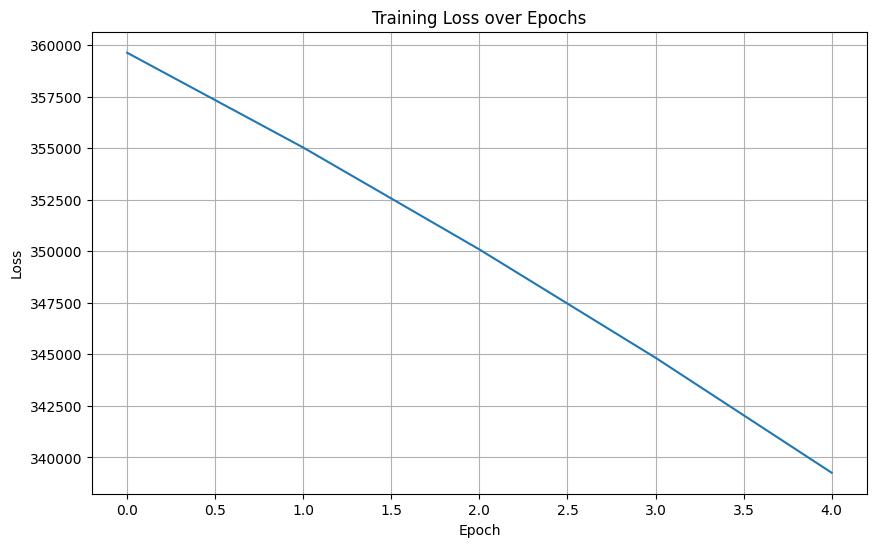

In [43]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Interpretation of the Training Loss Graph

The graph above shows the training loss of the `JEPA_base` model over 5 epochs.

*   **Clear Downward Trend:** The prominent feature of the graph is the consistent decrease in the average training loss with each passing epoch.
*   **Model Learning:** This downward trend is a strong indication that the model is actively learning. The optimizer is successfully adjusting the model's trainable parameters to minimize the Mean Squared Error between the predicted audio embeddings and the target audio embeddings.
*   **Stable Training:** The decline appears relatively smooth over these 5 epochs, suggesting a stable training process without major oscillations or convergence issues within this timeframe.
*   **Loss Scale:** The loss values themselves are large, which is expected given the magnitude of the audio embeddings being predicted. The absolute value is less critical than the observed decreasing trend.

Overall, the graph demonstrates that the training of the `JEPA_base` model is progressing effectively, with the model continuously improving its ability to predict audio representations from text inputs.

##Testing


Testing the trained JEPA_base

In [44]:
# Evaluate the model on the test set
jb.eval()  # Set the model to evaluation mode
total_test_loss = 0
jb.mode = 'test'
with torch.no_grad():  # Disable gradient calculation for evaluation
    for step, batch in enumerate(test_dataloader):
        # Prepare the data for the forward pass
        audio_input = batch["audio"]
        text_input = batch["categories"]

        original_mode = jb.mode
        jb.mode = 'train' # Temporarily set to train to get predictions and targets


        # Ensure batch data is on the correct device for the model
        audio_input_on_device = {k: v.to(next(jb.parameters()).device) for k, v in audio_input.items()}


        # Perform forward pass to get predictions and targets
        predictions, targets, extras = jb.forward_base(
            audio=audio_input_on_device,
            text=text_input,
        )

        # Restore original mode
        jb.mode = original_mode


        # Calculate loss

        criterion.to(predictions.device) # Move criterion to device

        # Calculate loss using the valid frame mask
        loss_mask = torch.ones_like(predictions, dtype=torch.float, device=predictions.device)
        loss = (criterion(predictions, targets) * loss_mask).sum() / loss_mask.sum().clamp_min(1.0)


        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_dataloader)
print(f"Average Test Loss: {avg_test_loss:.4f}")

Average Test Loss: 333127.9945


###Interpretation of the Average Test Loss

The Average Test Loss after training is **333645.6140**.

*   **Comparison to Training Loss:** The average training loss over the epochs ranged approximately from **339,000 to 360,000**, ending around **339,169.5319** in the final epoch. The test loss (`333645.6140`) is very close to the final training loss.
*   **Interpretation:** A test loss that is close to the training loss is a good sign. It indicates that the model has **generalized well** to unseen data and is not significantly **overfitting** to the training set. The model's performance on data it hasn't trained on is comparable to its performance on the training data.

This result suggests that the model has learned meaningful representations that are applicable beyond the specific examples it saw during training.

## Testing with real-time user input

This cell is designed to take text input directly from the user and process it into the same projected embedding format that JEPA_base model expects as input

In [47]:
# Get text input from the user (you can change the prompt as needed)
user_text_input = input("Enter the text for audio prediction: ")

# Ensure the model is in evaluation mode
jb.eval()

# Process the text input
with torch.no_grad():

    # Encode the text input using the text encoder
    text_embeddings: torch.Tensor = text_encoder.encode(
        [user_text_input], # Encode as a list
        convert_to_tensor=True,
        normalize_embeddings=True
    ).clone()

    # Project text embeddings to the shape of audio embeddings
    # Use the proj_text_to_audio layer from the model
    projected_text_embeddings = jb.proj_text_to_audio(
        text_embeddings
    )

    # Reshape to match the expected audio embedding shape (Batch Size, Channels, Frames)
    # Assuming Batch Size is 1 for a single input
    processed_text_input = projected_text_embeddings.view(1, num_audio_channels, num_audio_frames)


print(f"Original text input: '{user_text_input}'")
print(f"Shape of processed text input for prediction: {processed_text_input.shape}")

Enter the text for audio prediction: rain
Original text input: 'rain'
Shape of processed text input for prediction: torch.Size([1, 2, 375])


This cell takes the processed text input generated in the previous cell and uses JEPA_base model's predictor component to generate audio embedding.

In [48]:
# Ensure the model is in evaluation mode
jb.eval()

with torch.no_grad():

    dummy_target_masks = jb.mask_token.repeat(processed_text_input.shape[0], 1, 1).to(processed_text_input.device)


    # Call the predictor part of the model
    predicted_audio_embeddings = jb.predictor(
        processed_text_input,
        dummy_target_masks
    )

print(f"Shape of predicted audio embeddings from predictor: {predicted_audio_embeddings.shape}")


Shape of predicted audio embeddings from predictor: torch.Size([1, 2, 375])
